In [1]:
#from pprint import pprint   # only for this example
import matplotlib.pyplot as plt
from agilent_ir_file import AgilentIRFile
import library_OS_fit as lib_OS
import spec_process as spec_p
import numpy as np
import agilent_to_python as a2p
from scipy import stats
import pandas as pd
from collections import Counter

In [2]:
filename = r'C:\Users\Shreyas.Patankar\Ocean Wise Conservation Association\Plastics Lab Team - General\00_FTIR_Data\mosaic_test\m3\m3.dmt'

reader = AgilentIRFile()
reader.read(filename)

xvalues = reader.wavenumbers
intensities = reader.intensities
metadata = reader.metadata

print(xvalues)
print(intensities.shape)
#pprint(metadata)

[ 898.66574955  900.59421682  902.5226841  ... 3797.15206194 3799.08052921
 3801.00899649]
(256, 192, 1506)


In [3]:

#data = reader.read(filename)
#data
intensities = a2p.hsi_df(reader)
wavenumbers = a2p.data_wns(reader)

In [4]:
library_wavenos = lib_OS.get_lib_wns()

smoothing_order = 1
smoothing_window = 5


library_wavenos
proc = spec_p.proc(intensities[-219,154,:],smoothing_window, smoothing_order,wavenumbers,library_wavenos)
#plt.plot(library_wavenos,proc)

clust_der_values = pd.read_csv('OS_clusters_DERINT.csv')

def norm_pearson(p,q):
    modp = p/(np.max(p) - np.min(p))
    modq = q/(np.max(q) - np.min(q))
    return stats.pearsonr(modp,modq)[0]


def pearson_rs(p):
    def normp_pearson(q):
        return norm_pearson(p,q)
    return np.apply_along_axis(normp_pearson,axis=0,arr=clust_der_values)

np.argmax(pearson_rs(proc))
#pearson_rs(proc)
#lib_OS.libOS_fit_1(proc)

4

In [5]:

def bPR(p):
    proc = spec_p.proc(p,smoothing_window, smoothing_order,wavenumbers,library_wavenos)
    prsc = pearson_rs(proc)
    ix = np.argmax(prsc)
    if prsc[ix] > 0.3:
        return (ix , prsc[ix])
    else: return (0 , ix)

bPR(intensities[-229,154,:])
lib_OS.libOS_fit_1(proc).iloc[0,2:4].values
#vals = np.apply_along_axis(bPR,2,intensities)

np.max(reader.total_image)

llim = 300

#plt.imshow(np.where(reader.total_image > llim,1,0))
np.sum(np.where(reader.total_image > llim,1,0))
print(list(np.argwhere(reader.total_image > llim)))
ll = [tuple(k) for k in np.argwhere(reader.total_image > llim)]
#Counter([bPR(intensities[k]) for k in ll])


[array([ 18, 124], dtype=int64), array([ 18, 128], dtype=int64), array([ 18, 129], dtype=int64), array([ 18, 130], dtype=int64), array([ 18, 131], dtype=int64), array([ 18, 132], dtype=int64), array([ 18, 133], dtype=int64), array([ 18, 134], dtype=int64), array([ 18, 135], dtype=int64), array([ 18, 137], dtype=int64), array([ 18, 138], dtype=int64), array([ 19, 128], dtype=int64), array([ 19, 129], dtype=int64), array([ 19, 130], dtype=int64), array([ 19, 131], dtype=int64), array([ 19, 132], dtype=int64), array([ 19, 133], dtype=int64), array([ 19, 134], dtype=int64), array([ 19, 135], dtype=int64), array([ 19, 136], dtype=int64), array([ 19, 137], dtype=int64), array([ 19, 138], dtype=int64), array([ 19, 139], dtype=int64), array([ 19, 140], dtype=int64), array([ 19, 141], dtype=int64), array([ 20, 129], dtype=int64), array([ 20, 130], dtype=int64), array([ 20, 131], dtype=int64), array([ 20, 132], dtype=int64), array([ 20, 133], dtype=int64), array([ 20, 134], dtype=int64), array([

In [6]:
from scipy.signal import savgol_filter as sgf

def deriv(p, w):
    deriv_a = np.array(p) - np.roll(p,w)
    deriv_a[:w] = deriv_a[w]
    return deriv_a

def smoother(p, smoothing_window, smoothing_order):

        return np.array(sgf(p,smoothing_window,smoothing_order))

def bgF(p):
    return np.array(p)-np.array(smoother(p,1001,2))


In [7]:
rows = [k[0] for k in ll]
cols = [k[1] for k in ll]
idmap = np.zeros_like(reader.total_image)

idmap[rows,cols] = [bPR(intensities[k])[0] for k in ll]


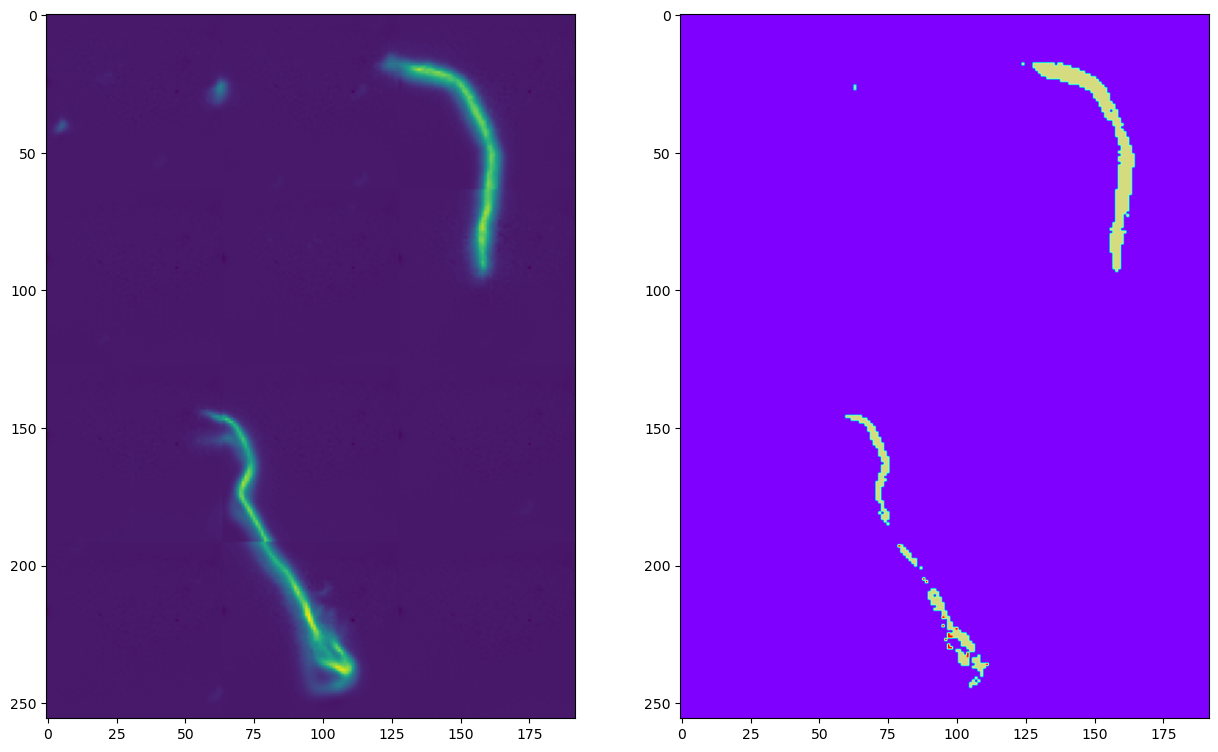

In [8]:
fig, axs = plt.subplots(1,2,figsize = (15,30))
axs[0].imshow(reader.total_image)
axs[1].imshow(idmap, cmap = 'rainbow')




In [20]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

np.random.seed(1)
n = 10
l = 256
im = np.zeros((l, l))
points = l*np.random.random((2, n**2))
im[(points[0]).astype(int), (points[1]).astype(int)] = 1
im = ndimage.gaussian_filter(im, sigma=l/(4.*n))


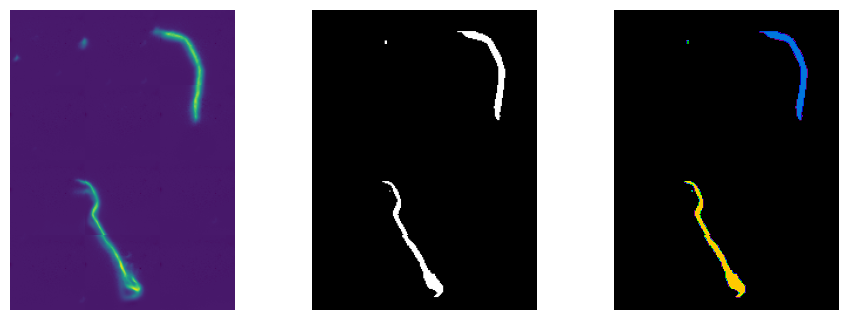

In [101]:
im = reader.total_image
mask = im > 500*im.mean()

label_im, nb_labels = ndimage.label(mask)

plt.figure(figsize=(9,3))

plt.subplot(131)
plt.imshow(im)
plt.axis('off')
plt.subplot(132)
plt.imshow(mask, cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(133)
mask_size = sizes > 500
remove_pixel = mask_size[label_im]
remove_pixel.shape

label_im[remove_pixel] = 0
plt.imshow(label_im, cmap=plt.cm.nipy_spectral)
plt.axis('off')

plt.subplots_adjust(wspace=0.02, hspace=0.02, top=1, bottom=0, left=0, right=1)
plt.show()

In [102]:
sizes = ndimage.sum(mask, label_im, range(nb_labels + 1))
print(sizes)
nb_labels

[  0. 512.   6. 562.   1.]


4

In [97]:
bPR(intensities[240,107])

(0, 6)

In [98]:
import time
p = intensities[-218,154,:]
start = time.time()
pearson_rs(proc)
end = time.time()

print('eval time = ', end - start)

eval time =  0.048378705978393555


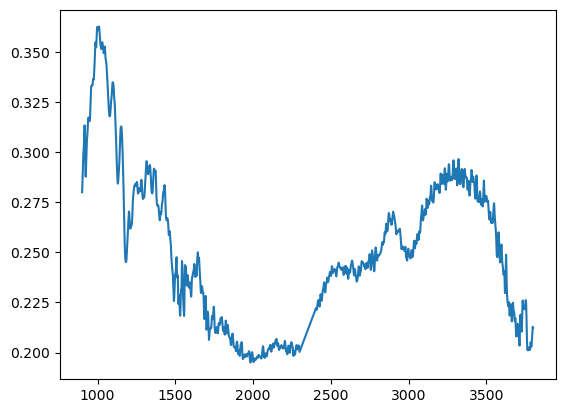

In [99]:
plt.plot(wavenumbers,intensities[-219,154,:])